In [45]:
import sys
import os
#import random forrest from sklearn 
from sklearn.ensemble import RandomForestClassifier


sys.path.append(os.path.abspath('../../src'))

# add functions explicitly to the path
from utils import *
from data_cleaning import *
from pipeline import *

from sklearn.metrics import f1_score

In [46]:
df_X, df_y = load_data_train()

In [47]:
df_X = convert_to_object(df_X)
df_X['geo_level_1_id'] = df_X['geo_level_1_id'].astype('object')
df_X['geo_level_2_id'] = df_X['geo_level_2_id'].astype('object')
df_X['geo_level_3_id'] = df_X['geo_level_3_id'].astype('object')

In [48]:
df_X, df_y = drop_duplicates(df_X,df_y)

In [49]:
outliers_ids = get_outliers_ids(df_X)

tot number of outliers: 10526
- count_floors_pre_eq - number of outliers: 2439
- age - number of outliers: 1259
- area_percentage - number of outliers: 3811
- height_percentage - number of outliers: 2407
- count_families - number of outliers: 2325


In [50]:
df_X, df_y = drop_row(outliers_ids.tolist(), df_X, df_y)

In [51]:
# we will start building features, 
# one feature is build material , 
# build material is a categorical data and it containst following materials : 
# stone , cement , brick , wood , 


# Assuming df_X contains the data
df_X["sticking_material"] = df_X[['has_superstructure_mud_mortar_stone',
                                  'has_superstructure_mud_mortar_brick',
                                  'has_superstructure_cement_mortar_stone',
                                  'has_superstructure_cement_mortar_brick']].idxmax(axis=1)

df_X["sticking_material"] = df_X["sticking_material"].map({
    'has_superstructure_mud_mortar_stone': 'mud',
    'has_superstructure_mud_mortar_brick': 'mud',
    'has_superstructure_cement_mortar_stone': 'cement',
    'has_superstructure_cement_mortar_brick': 'cement'
}).fillna("none")  # If none of these are present

df_X["building_material"] = df_X[['has_superstructure_adobe_mud',
                                  'has_superstructure_mud_mortar_stone',
                                  'has_superstructure_stone_flag',
                                  'has_superstructure_mud_mortar_brick',
                                  'has_superstructure_cement_mortar_stone',
                                  'has_superstructure_cement_mortar_brick',
                                  'has_superstructure_timber',
                                  'has_superstructure_bamboo']].idxmax(axis=1)

df_X["building_material"] = df_X["building_material"].map({
    'has_superstructure_adobe_mud': 'adobe',
    'has_superstructure_mud_mortar_stone': 'stone',
    'has_superstructure_stone_flag': 'stone',
    'has_superstructure_mud_mortar_brick': 'brick',
    'has_superstructure_cement_mortar_stone': 'stone',
    'has_superstructure_cement_mortar_brick': 'brick',
    'has_superstructure_timber': 'wood',
    'has_superstructure_bamboo': 'wood'
}).fillna("other")  # Default category if none match

df_X["is_concrete"] = df_X[['has_superstructure_rc_non_engineered',
                            'has_superstructure_rc_engineered']].max(axis=1)

df_X["is_concrete"] = df_X["is_concrete"].apply(lambda x: "True" if x > 0 else "False")  # Convert to binary



# and another feature is type of building : 
# agricultureal , institutional (hotel, school , gov office , police office ) , industrial , other ( which contains rental health post and other (probably residential))

# we should also Xplore effectivness of these categories in building health . using plotting would be great . 
df_X["type_of_building"] = df_X[['has_secondary_use_agriculture',
                                'has_secondary_use_hotel',
                                'has_secondary_use_rental', 
                                'has_secondary_use_institution',
                                'has_secondary_use_school', 
                                'has_secondary_use_industry',
                                'has_secondary_use_health_post', 
                                'has_secondary_use_gov_office',
                                'has_secondary_use_use_police', 
                                'has_secondary_use_other',
                                'has_secondary_use'                        
                                 ]].idxmax(axis=1)


df_X["type_of_building"] = df_X["type_of_building"].map({
        

                                'has_secondary_use_agriculture':"agriculture",
                                'has_secondary_use_hotel':"institutional",
                                'has_secondary_use_rental':"other", 
                                'has_secondary_use_institution':"institutional",
                                'has_secondary_use_school':"institutional", 
                                'has_secondary_use_industry' :"industrial",
                                'has_secondary_use_health_post':"other", 
                                'has_secondary_use_gov_office':"institutional",
                                'has_secondary_use_use_police':"institutional", 
                                'has_secondary_use_other':"other",
                                'has_secondary_use':"other"                 
                                 


}).fillna("other")
        
   






In [52]:
numerical_feature

['count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage',
 'count_families',
 'is_concrete']

In [53]:
categorical_feature

['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'sticking_material',
 'building_material',
 'type_of_building']

In [54]:
df_y = df_y.drop(['building_id'], axis=1)
df_X = df_X.drop(['building_id'], axis=1)

In [55]:
numerical_feature = df_X.select_dtypes(include=['number']).columns.tolist()
categorical_feature = df_X.select_dtypes(include=['object']).columns.tolist()

In [56]:
categorical_feature = [
    'geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',

'sticking_material',
 'building_material',
 'type_of_building',
 'is_concrete'


]

In [57]:
standard_scaler_cols = numerical_feature
robust_scaler_cols = []
baseN_enc_cols = categorical_feature
ordinal_enc_cols = []
one_hot_cols = []

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42, stratify=df_y)

In [58]:
model = RandomForestClassifier(n_estimators=100, random_state=0)

pre_proccessor = pipeline_preprocessor(standard_scaler_cols=standard_scaler_cols,baseN_enc_cols=baseN_enc_cols)
pipeline = classifier_pipeline(pre_proccessor, model)

In [59]:
model_fit = model_training(X_train,y_train,pipeline)

/home/shahab/git/Earthquake-competition/env/dsr-competition/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [11]:
model_fit

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['count_floors_pre_eq', 'age',
                                                   'area_percentage',
                                                   'height_percentage',
                                                   'count_families']),
                                                 ('robust_scaler',
                                                  RobustScaler(), []),
                                                 ('baseN_encoder',
                                                  BaseNEncoder(cols=['geo_level_1_id',
                                                                     'geo_level_2_id',
                                                                     'geo_level_3_id',
                                                                     'land_surface_condition',
                                                                     'foundation_typ...
                                                   'legal_ownership_status',
                                                   'has_secondary_use',
                                                   'has_secondary_use_agriculture',
                                                   'has_secondary_use_hotel',
                                                   'has_secondary_use_rental',
                                                   'has_secondary_use_institution',
                                                   'has_secondary_use_school',
                                                   'has_secondary_use_industry',
                                                   'has_secondary_use_health_post', ...]),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(), [])])),
                ('classifier', RandomForestClassifier(random_state=0))])

In [60]:
y_pred = model_fit.predict(X_test)
score = f1_score(y_test, y_pred, average='micro')
print(score)

0.7164418410757424


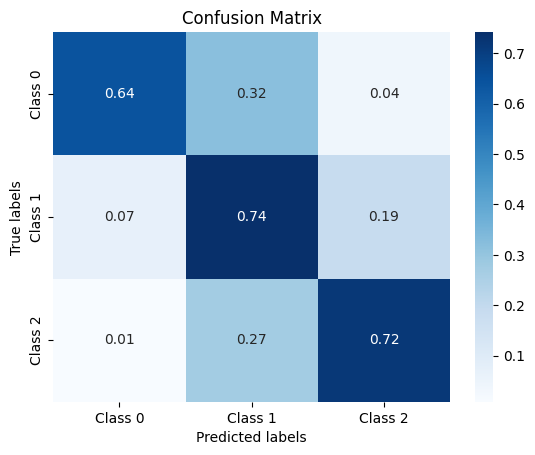

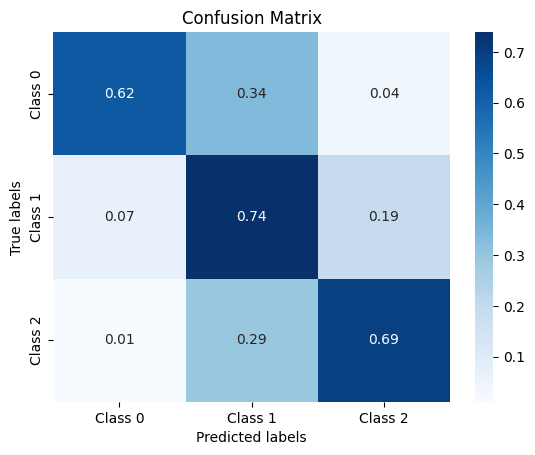

In [61]:
print_confusion_matrix(y_test, y_pred)

In [36]:
# test the model
df_test = load_data_test()
df_test = convert_to_object(df_test)
df_test_id = df_test.pop('building_id')

In [37]:
test_predictions = model_fit.predict(df_test)
df_submission = pd.DataFrame({'building_id': df_test_id, 'damage_grade': test_predictions})

In [20]:
df_submission

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,2
86865,1049160,2
86866,442785,2


In [28]:
df_submission.to_csv('../../results/20250129_16_24_submission.csv', index=False)